In [1]:
import matplotlib.pyplot as plt

# import numpy as np
# import cv2

from skimage import feature, exposure
# from skimage import data, exposure
# from skimage import io, color
# from skimage import filters

# from skimage.feature import hog
from skimage.transform import pyramid_gaussian
# from skimage import color
# import numpy as np
# import cv2
# import os
# import glob

from skimage.io import imread
import sklearn.svm
from sklearn.svm import LinearSVC
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from skimage import color
import numpy as np
import argparse
import cv2
import os
import glob
from PIL import Image # This will be used to read/modify images (can be done via OpenCV too)
from numpy import *

from skimage.feature import hog
from skimage.transform import pyramid_gaussian
from skimage import color
import numpy as np
import cv2
import os
import glob

In [2]:
# define path to images:
pos_im_path = r"./images/gadoP" # This is the path of our positive input dataset
# define the same for negatives
neg_im_path= r"./images/gadoN"

# read the image files:
pos_im_listing = os.listdir(pos_im_path) # it will read all the files in the positive image path (so all the required images)
neg_im_listing = os.listdir(neg_im_path)
num_pos_samples = size(pos_im_listing) # simply states the total no. of images
num_neg_samples = size(neg_im_listing)
print(num_pos_samples) # prints the number value of the no.of samples in positive dataset
print(num_neg_samples)

468
132


In [3]:
def show_hog_images(img, hog_image):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(img, cmap=plt.cm.gray)
    ax1.set_title('Input image')

    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    ax2.axis('off')
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    plt.show()

In [4]:
def ajust_img(img):
    img = img.resize((128,64))
#     print('normal')
#     print(img)
    shifted = cv2.pyrMeanShiftFiltering(np.array(img), sp=15, sr=25)
    img = Image.fromarray(shifted)
#     img.show()
#     print('mean')
#     print(img)
    gray = img.convert('L') # convert the image into single channel i.e. RGB to grayscale
    return img

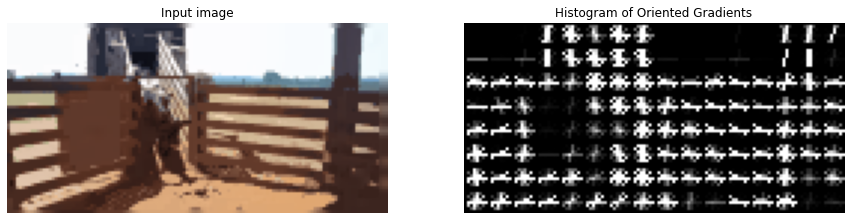

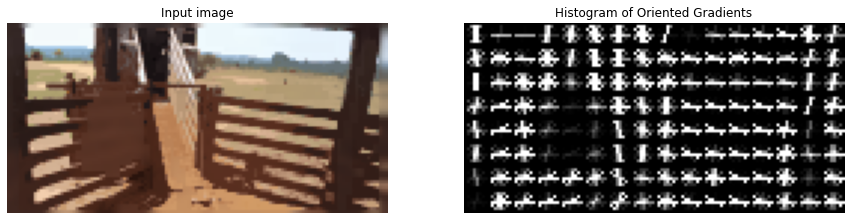

In [5]:
# define parameters of HOG feature extraction
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (1, 1)
threshold = .3


data= []
labels = []


def get_fd_hog_test(img):
    img = img.resize((128,64))
#     print('normal')
#     print(img)
    shifted = cv2.pyrMeanShiftFiltering(np.array(img), sp=15, sr=25)
    img = Image.fromarray(shifted)
#     img.show()
#     print('mean')
#     print(img)
    gray = img.convert('L') # convert the image into single channel i.e. RGB to grayscale
    # calculate HOG for positive features
    fd, hog = feature.hog(gray, orientations, pixels_per_cell, cells_per_block,
                        block_norm='L2', visualize=True, feature_vector=True)# fd= feature descriptor
    show_hog_images(img, hog)
    
def get_fd_hog(img):
    img = img.resize((128,64))
    shifted = cv2.pyrMeanShiftFiltering(np.array(img), sp=15, sr=25)
    img = Image.fromarray(shifted)
    gray = img.convert('L') # convert the image into single channel i.e. RGB to grayscale
    # calculate HOG for positive features
    fd = feature.hog(gray, orientations, pixels_per_cell, cells_per_block,
                        block_norm='L2', feature_vector=True)# fd= feature descriptor
    return fd

# compute HOG features and label them:
# for file in [pos_im_listing[0]]:
for file in pos_im_listing: #this loop enables reading the files in the pos_im_listing variable one by one
    img = Image.open(pos_im_path + '/' + file) # open the file
    fd = get_fd_hog(img)
    data.append(fd)
    labels.append(1)
get_fd_hog_test(img)

# Same for the negative images
# for file in [neg_im_listing[0]]:
for file in neg_im_listing:
    img= Image.open(neg_im_path + '/' + file)
    fd = get_fd_hog(img)
    data.append(fd)
    labels.append(0)
get_fd_hog_test(img)
    
# encode the labels, converting them from strings to integers
le = LabelEncoder()
labels = le.fit_transform(labels)



In [6]:
# img.shape
img.size

(853, 480)

In [7]:
#%%
# Partitioning the data into training and testing splits, using 80%
# of the data for training and the remaining 20% for testing
print(" Constructing training/testing split...")
(trainData, testData, trainLabels, testLabels) = train_test_split(
	np.array(data), labels, test_size=0.20, random_state=42)
#%% Train the linear SVM
print(" Training Linear SVM classifier...")
model = LinearSVC()
model.fit(trainData, trainLabels)
#%% Evaluate the classifier
print(" Evaluating classifier on test data ...")
predictions = model.predict(testData)
print(classification_report(testLabels, predictions))


# Save the model:
#%% Save the Model
joblib.dump(model, 'model_bovinos.npy')

 Constructing training/testing split...
 Training Linear SVM classifier...
 Evaluating classifier on test data ...
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        28
           1       0.97      0.95      0.96        92

    accuracy                           0.93       120
   macro avg       0.90      0.92      0.91       120
weighted avg       0.94      0.93      0.93       120



['model_bovinos.npy']

In [21]:
# Testing Trained Model

#Define HOG Parameters
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
threshold = .3

# define the sliding window:
def sliding_window(image, stepSize, windowSize):# image is the input, step size is the no.of pixels needed to skip and windowSize is the size of the actual window
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):# this line and the line below actually defines the sliding part and loops over the x and y coordinates
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y: y + windowSize[1], x:x + windowSize[0]])
#%%
# Upload the saved svm model:
model = joblib.load('model_bovinos.npy')

# Test the trained classifier on an image below!
scale = 0
detections = []
# read the image you want to detect the object in:
# img= cv2.imread("images/testP/135.png", cv2.IMREAD_GRAYSCALE)
# img = io.imread('images/testP/135.png', as_gray=False)
img = Image.open("images/testP/135.png") # open the file

# print(img.size)

# img = img.resize((64,128))

# show_hog_images(io.imread('images/testP/135.png', 0), img)

img = ajust_img(img)

# Try it with image resized if the image is too big
# img= cv2.resize(img,(300,200)) # can change the size to default by commenting this code out our put in a random number

# defining the size of the sliding window (has to be, same as the size of the image in the training data)
(winW, winH)= (64,128)
windowSize=(winW,winH)
downscale=1.5
# Apply sliding window:
for resized in pyramid_gaussian(img, downscale=1.5): # loop over each layer of the image that you take!
    # loop over the sliding window for each layer of the pyramid
    for (x,y,window) in sliding_window(resized, stepSize=10, windowSize=(winW,winH)):
        # if the window does not meet our desired window size, ignore it!
        if window.shape[0] != winH or window.shape[1] !=winW: # ensure the sliding window has met the minimum size requirement
            continue
        window=color.rgb2gray(window)
        fds, hog = feature.hog(window, orientations, pixels_per_cell, cells_per_block, block_norm='L2')  # extract HOG features from the window captured
        fds = fds.reshape(1, -1) # re shape the image to make a silouhette of hog
        pred = model.predict(fds) # use the SVM model to make a prediction on the HOG features extracted from the window
        
        if pred == 1:
            if model.decision_function(fds) > 0.6:  # set a threshold value for the SVM prediction i.e. only firm the predictions above probability of 0.6
                print("Detection:: Location -> ({}, {})".format(x, y))
                print("Scale ->  {} | Confidence Score {} \n".format(scale,model.decision_function(fds)))
                detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), model.decision_function(fds),
                                   int(windowSize[0]*(downscale**scale)), # create a list of all the predictions found
                                      int(windowSize[1]*(downscale**scale))))
    scale+=1
    
clone = resized.copy()
for (x_tl, y_tl, _, w, h) in detections:
    cv2.rectangle(img, (x_tl, y_tl), (x_tl + w, y_tl + h), (0, 0, 255), thickness = 2)
rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections]) # do nms on the detected bounding boxes
sc = [score[0] for (x, y, score, w, h) in detections]
print("detection confidence score: ", sc)




detection confidence score:  []


In [20]:
from tensorflow import image

sc = np.array(sc)
pick = image.non_max_suppression(rects, scores=sc, max_output_size=1, iou_threshold = 0.3)

# the peice of code above creates a raw bounding box prior to using NMS
# the code below creates a bounding box after using nms on the detections
# you can choose which one you want to visualise, as you deem fit... simply use the following function:
# cv2.imshow in this right place (since python is procedural it will go through the code line by line).


for (xA, yA, xB, yB) in pick:
    cv2.rectangle(img, (xA, yA), (xB, yB), (0,255,0), 2)
cv2.imshow("Raw Detections after NMS", img)


InvalidArgumentError: boxes must be 2-D[0] [Op:NonMaxSuppressionV3]

In [ ]:
#### Save the images below
cv2.waitKey(0) & 0xFF 
if k == 27:             #wait for ESC key to exit
    cv2.destroyAllWindows()
elif k == ord('s'):
    cv2.imwrite('Path\to_the_directory\of_saved_image.png',img)
    cv2.destroyAllWindows()